In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Generate dummy data

In [2]:
# True parameter values
true_z = 0.69

# Size of dataset
size = 10

# Generate Tosses
x = np.random.binomial(n=1, p=true_z, size=size)

In [4]:
x

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0])

In [5]:
np.mean(x)

0.7

# Prior Constants

In [6]:
alpha, beta = 10, 10

## Analytical Solution

In [9]:
from scipy.stats import beta as beta_dist

# analytical solution for p(z | x)
def posterior_dist(z, x, alpha, beta):
    a = alpha + x.sum()
    b = beta + len(x) - x.sum()

    return beta_dist.pdf(z, a, b)

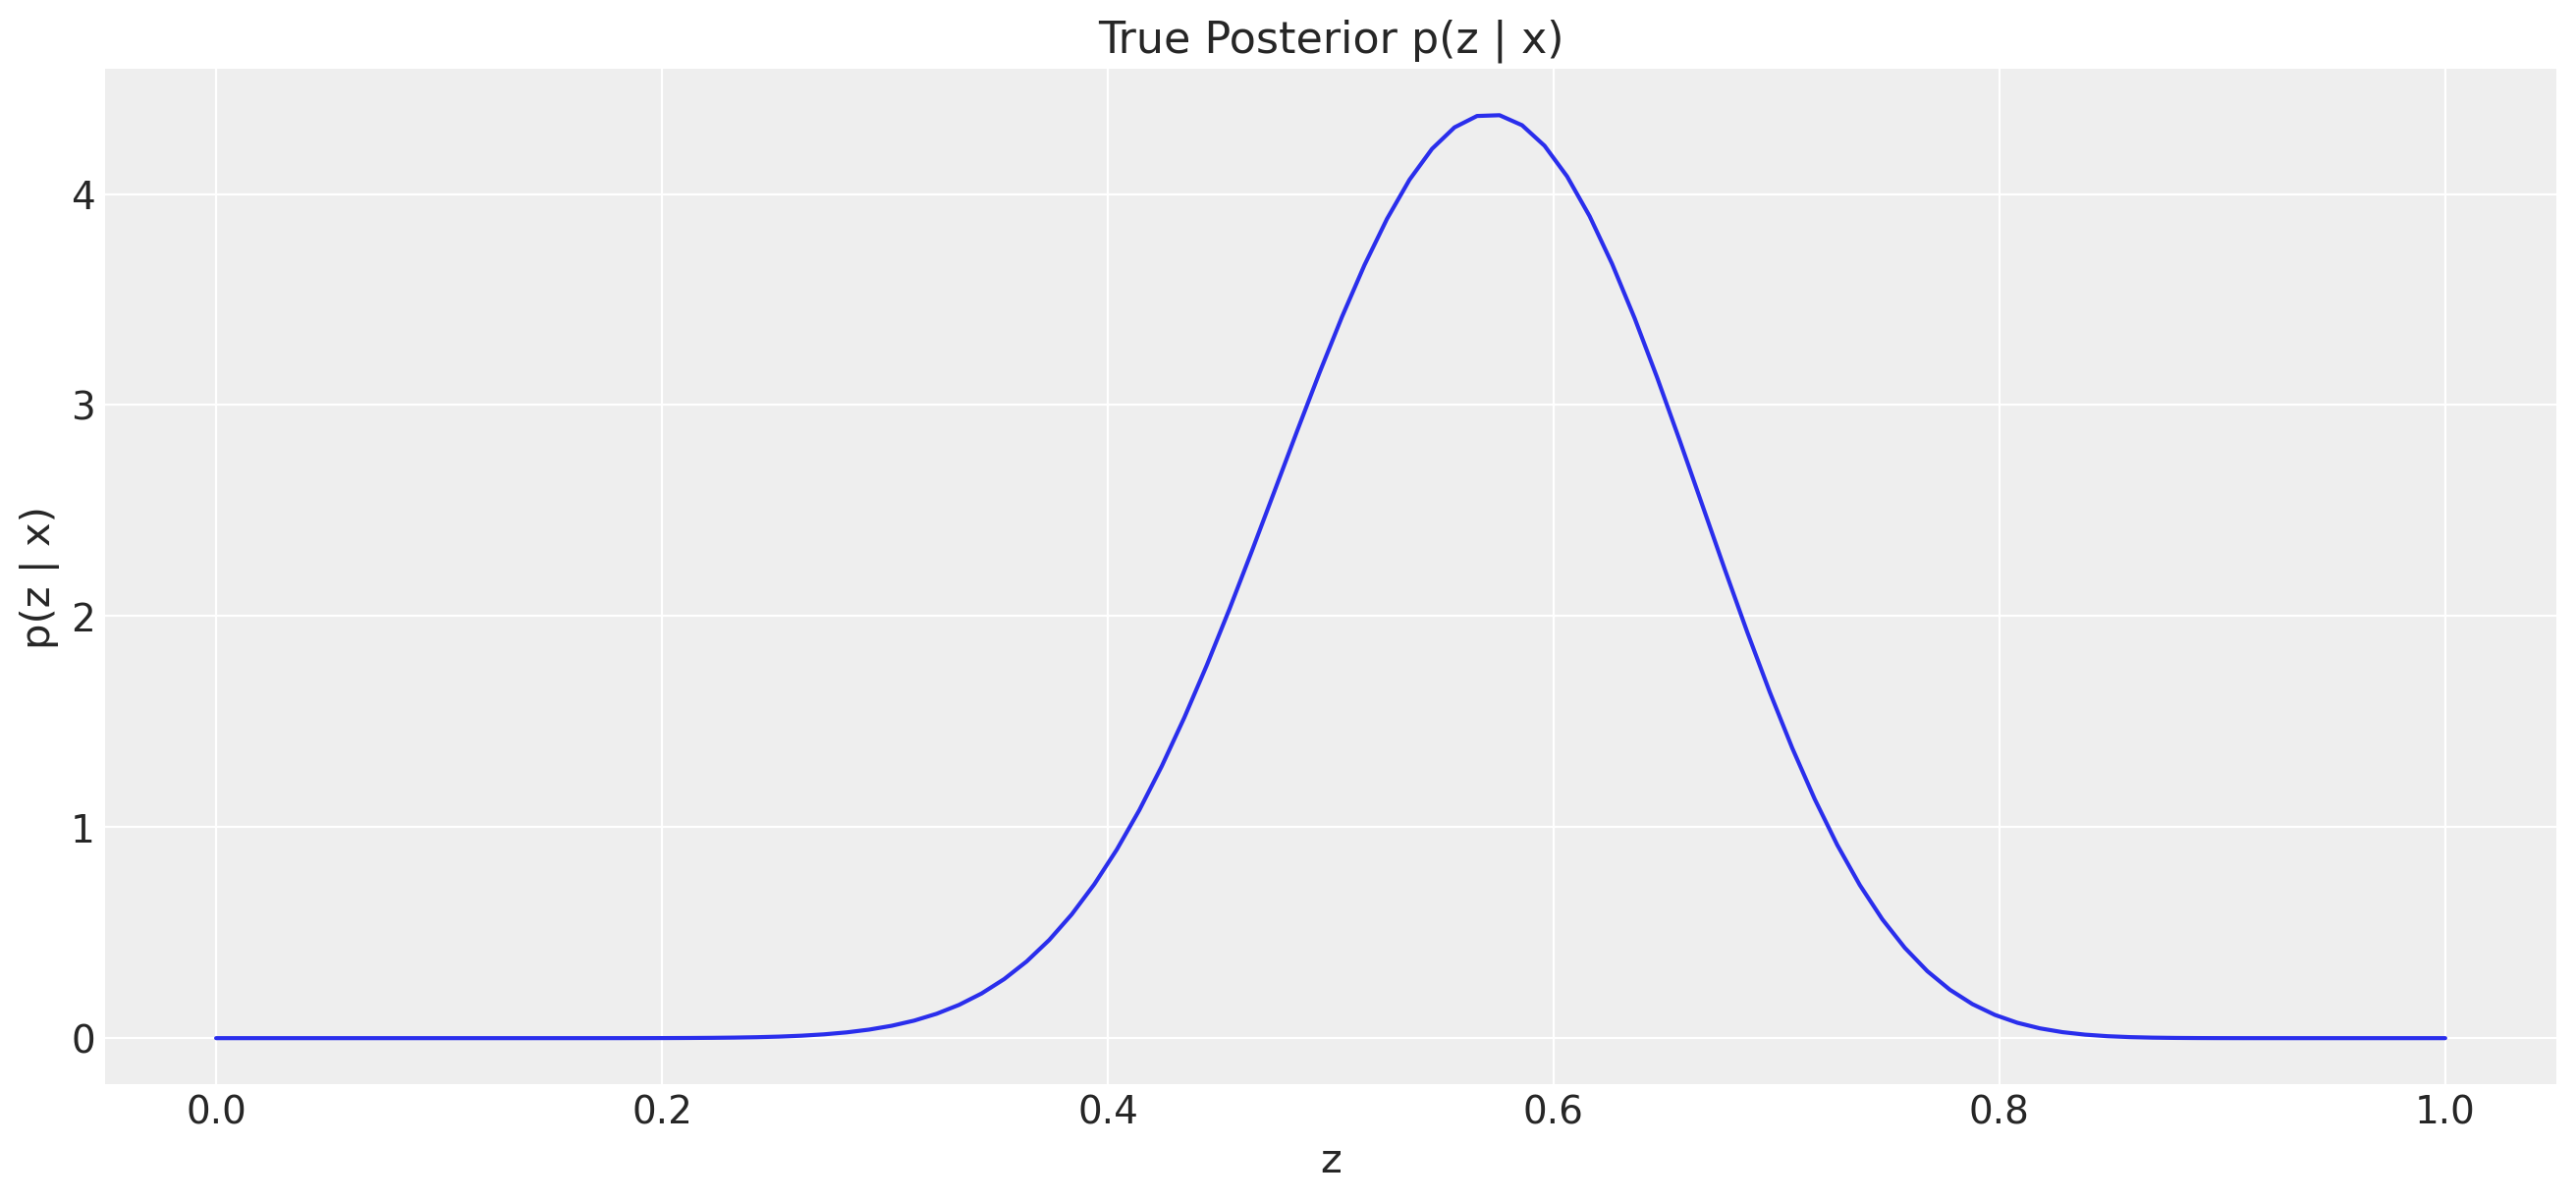

In [10]:
# plot posterior over pi in range [0,1]
z_range = np.linspace(0, 1, 100)
posterior = [posterior_dist(z_i, x, alpha, beta) for z_i in z_range]

plt.figure(figsize=(13,6))
plt.plot(z_range, posterior)
plt.xlabel("z")
plt.ylabel("p(z | x)")
plt.title("True Posterior p(z | x)")
plt.show()

# Define the model using Probabilistic Programming!

In [11]:
import pymc as pm

model = pm.Model()
alpha, beta = 10, 10

with model:
    # Prior p(z)
    z = pm.Beta("z", alpha=alpha, beta=beta)

    # Likelihood p(x | z)
    x_likelihood = pm.Bernoulli("x_likelihood", p=z, observed=x)

# Approximate Inference using MCMC

In [12]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [13]:
# animation of histogram as sampling progresses
# plot mcmc_posterior histogram as sampling progresses

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(8, 4))
ax.set(xlim=(0, 1), ylim=(0, 10))
ax.set_ylabel("Posterior Density")
ax.set_xlabel("z")
ax.set_title("Sampling the posterior over z")
plt.close()

line, = ax.plot([], [], lw=3)
annotation = ax.text(
    0.4, 8.0, "", fontsize=16, bbox=dict(boxstyle="square", fc="white")
)
x_range = np.linspace(0

SyntaxError: incomplete input (850082103.py, line 18)

/usr/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


NameError: name 'HTML' is not defined

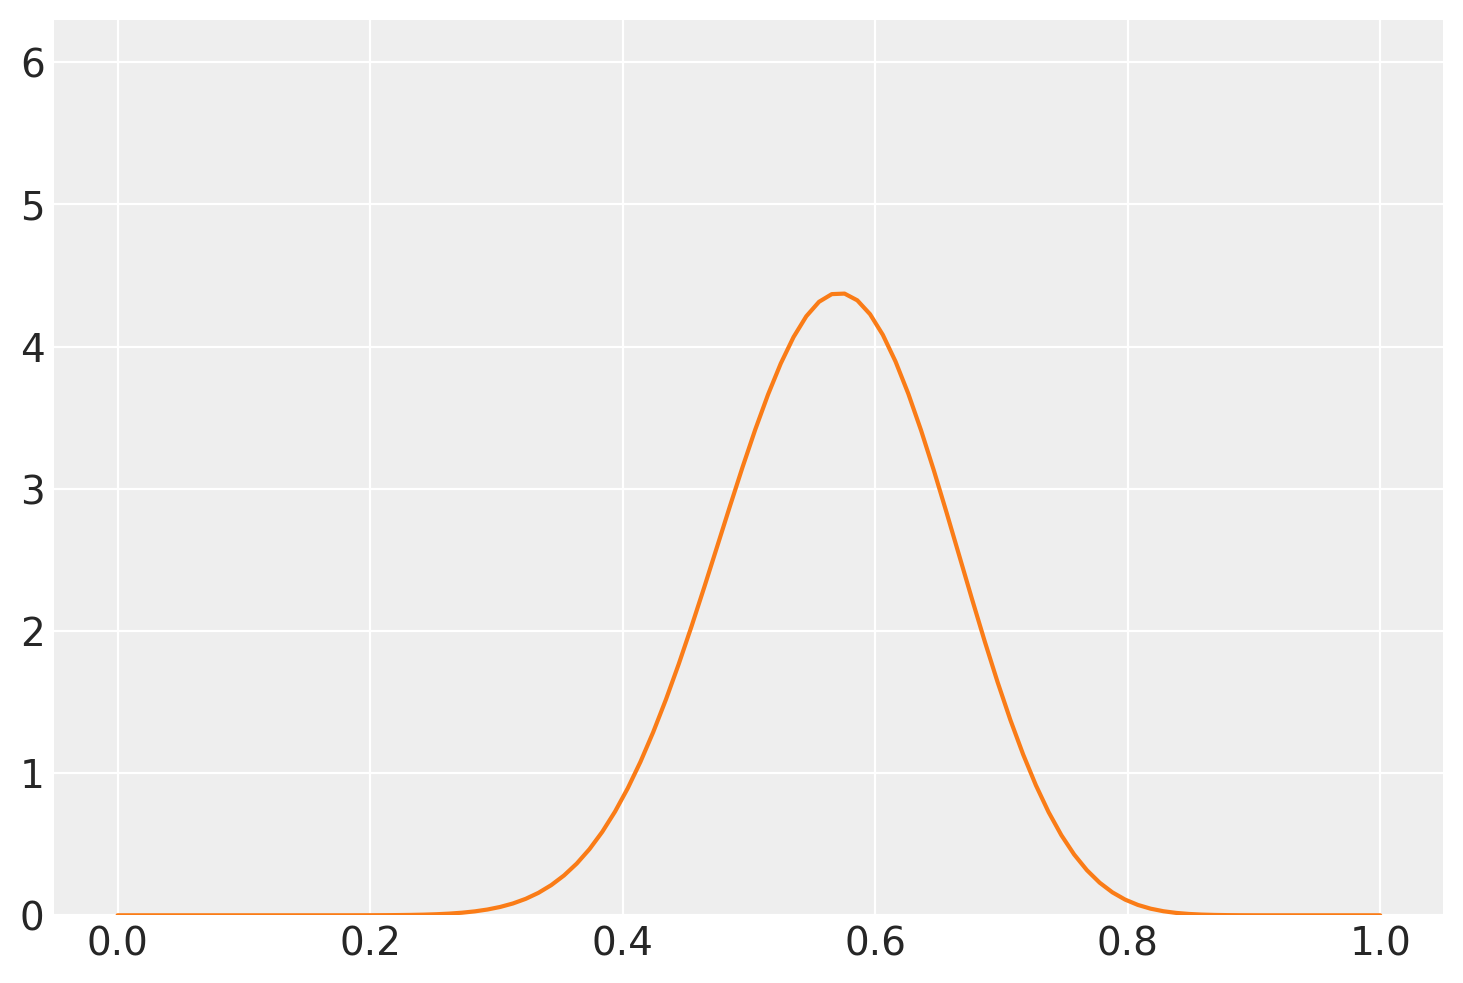

In [14]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(0, 1, 50)

# histogram our data with numpy
mcmc_posterior = np.array(idata.posterior['z']).flatten()
n, _ = np.histogram(mcmc_posterior[:20], HIST_BINS)


def prepare_animation(bar_container):
    def animate(frame_number):
        # print("Animating frame", frame_number)
        i = frame_number * 20
        data = mcmc_posterior[:i]
        # simulate new data coming in
        n, _ = np.histogram(data, HIST_BINS, density=True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate

# Output generated via `matplotlib.animation.Animation.to_jshtml`.

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(mcmc_posterior[:20], HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
# ax.set_ylim(top=55)  # set safe limit to ensure that all data is visible.
# ax.figure(figsize=(13,6))
z_range = np.linspace(0, 1, 100)
ax.plot(z_range, posterior, label="True posterior")
    # plt.xlabel("z")
    # plt.ylabel("p(z | x)")
    # plt.title(f"MCMC posterior after {i} samples")
    # plt.legend()
    # plt.show()


ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
# add play button (jupyter notebook only)
HTML(ani.to_jshtml())


In [15]:
from IPython.display import HTML
HTML(ani.to_html5_video())

/usr/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0


NameError: name 'x_range' is not defined

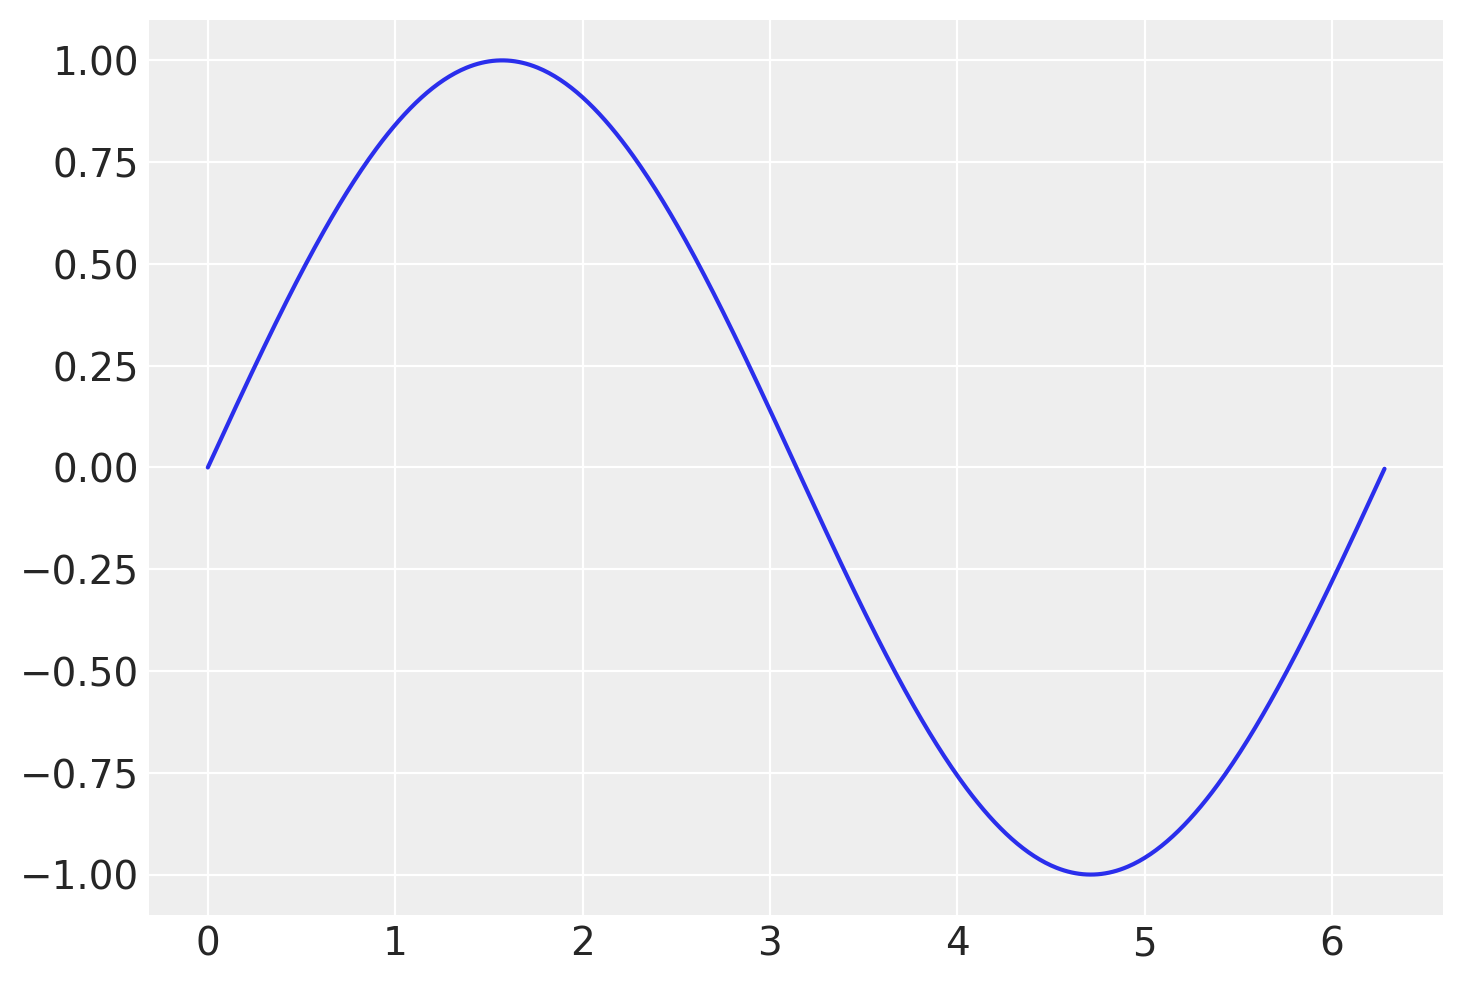

In [27]:
import matplotlib.animation as animation



fig, ax = plt.subplots()
x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))

def animate(i):
    print(i)
    line.set_data(x_range[:i], mcmc_posterior[:i])
    return line,

ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

plt.show()

In [ ]:

# plot histogram of samples
chunk_size = 10
for i in range(0, len(mcmc_posterior), chunk_size):
    samples = mcmc_posterior[:i]
    # plot histogram of samples
    plt.figure(figsize=(13,6))
    plt.hist(samples, bins=20, density=True, label="MCMC posterior", alpha=0.5, color="red")
    plt.plot(z_range, posterior, label="True posterior")
    plt.xlabel("z")
    plt.ylabel("p(z | x)")
    plt.title(f"MCMC posterior after {i} samples")
    plt.legend()
    plt.show()

    if i == 40:
        break



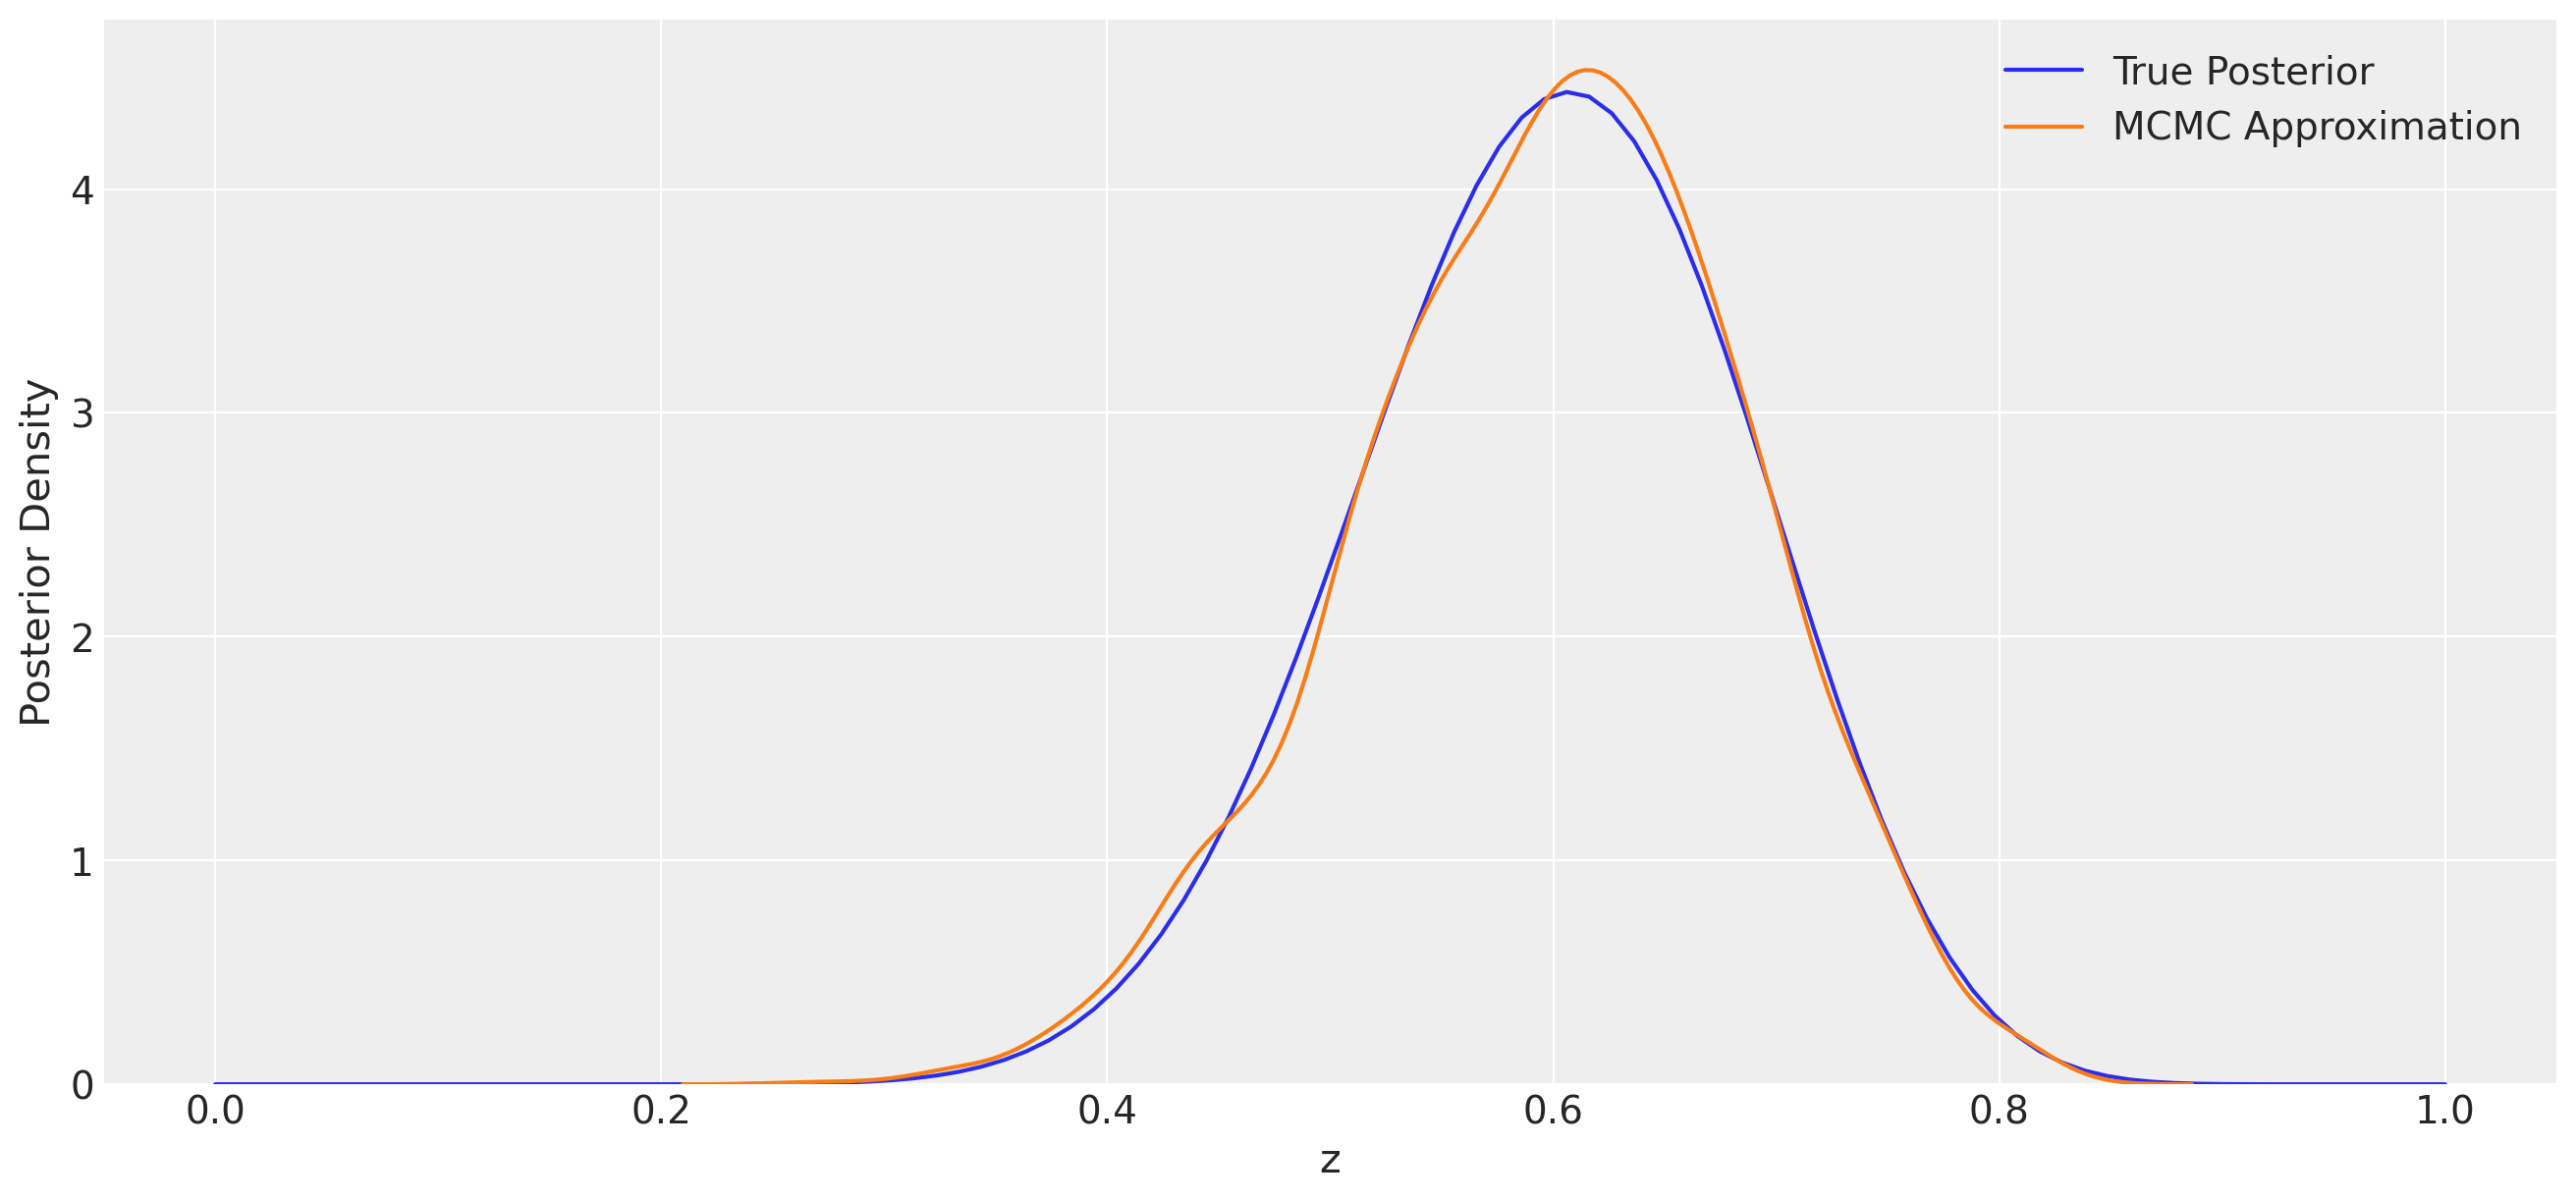

In [13]:
mcmc_posterior = np.array(idata.posterior['z']).flatten()
# change figure size
plt.figure(figsize=(13,6))
sns.lineplot(x=z_range, y=posterior)
sns.kdeplot(mcmc_posterior)
plt.xlabel('z'); plt.ylabel('Posterior Density')
plt.legend(labels=['True Posterior', 'MCMC Approximation'])
plt.show()

# Pyro

In [16]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

from tqdm import tqdm

x = [torch.tensor(x_i, dtype=torch.float32) for x_i in x]
alpha, beta = torch.tensor(alpha), torch.tensor(beta)

## Define the model using Pyro

In [18]:
def model(x):
    # Prior p(z)
    z = pyro.sample("z", dist.Beta(alpha, beta))

    # Likelihood p(x | z)
    for i in range(len(x)):
        pyro.sample(f"x_{i}_likelihood", dist.Bernoulli(z), obs=x[i])

Since we perform *variational* inference, we need to specify a **variational distribution** $q_\phi(\mathbf{z})$. 

In this example, we choose $$q_\phi(\mathbf{z}) = \text{Beta}(\mathbf{z}; \alpha_q, \beta_q)$$i.e., $\phi = (\alpha_q, \beta_q)^T$.

In [19]:
def variational_distribution(x):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)

    # Define q(z)
    pyro.sample("z", dist.Beta(alpha_q, beta_q))

# Approximate Inference using Variational Inference

In [20]:
optimizer = Adam({"lr": 1e-3})
# Stochastic Variational Inference
svi = SVI(model, variational_distribution, optimizer, loss=Trace_ELBO())

# Use Adam to maximize the ELBO (w.r.t. phi)
for step in tqdm(range(3000)):
    svi.step(x)

100%|██████████| 3000/3000 [00:14<00:00, 204.30it/s]


In [21]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

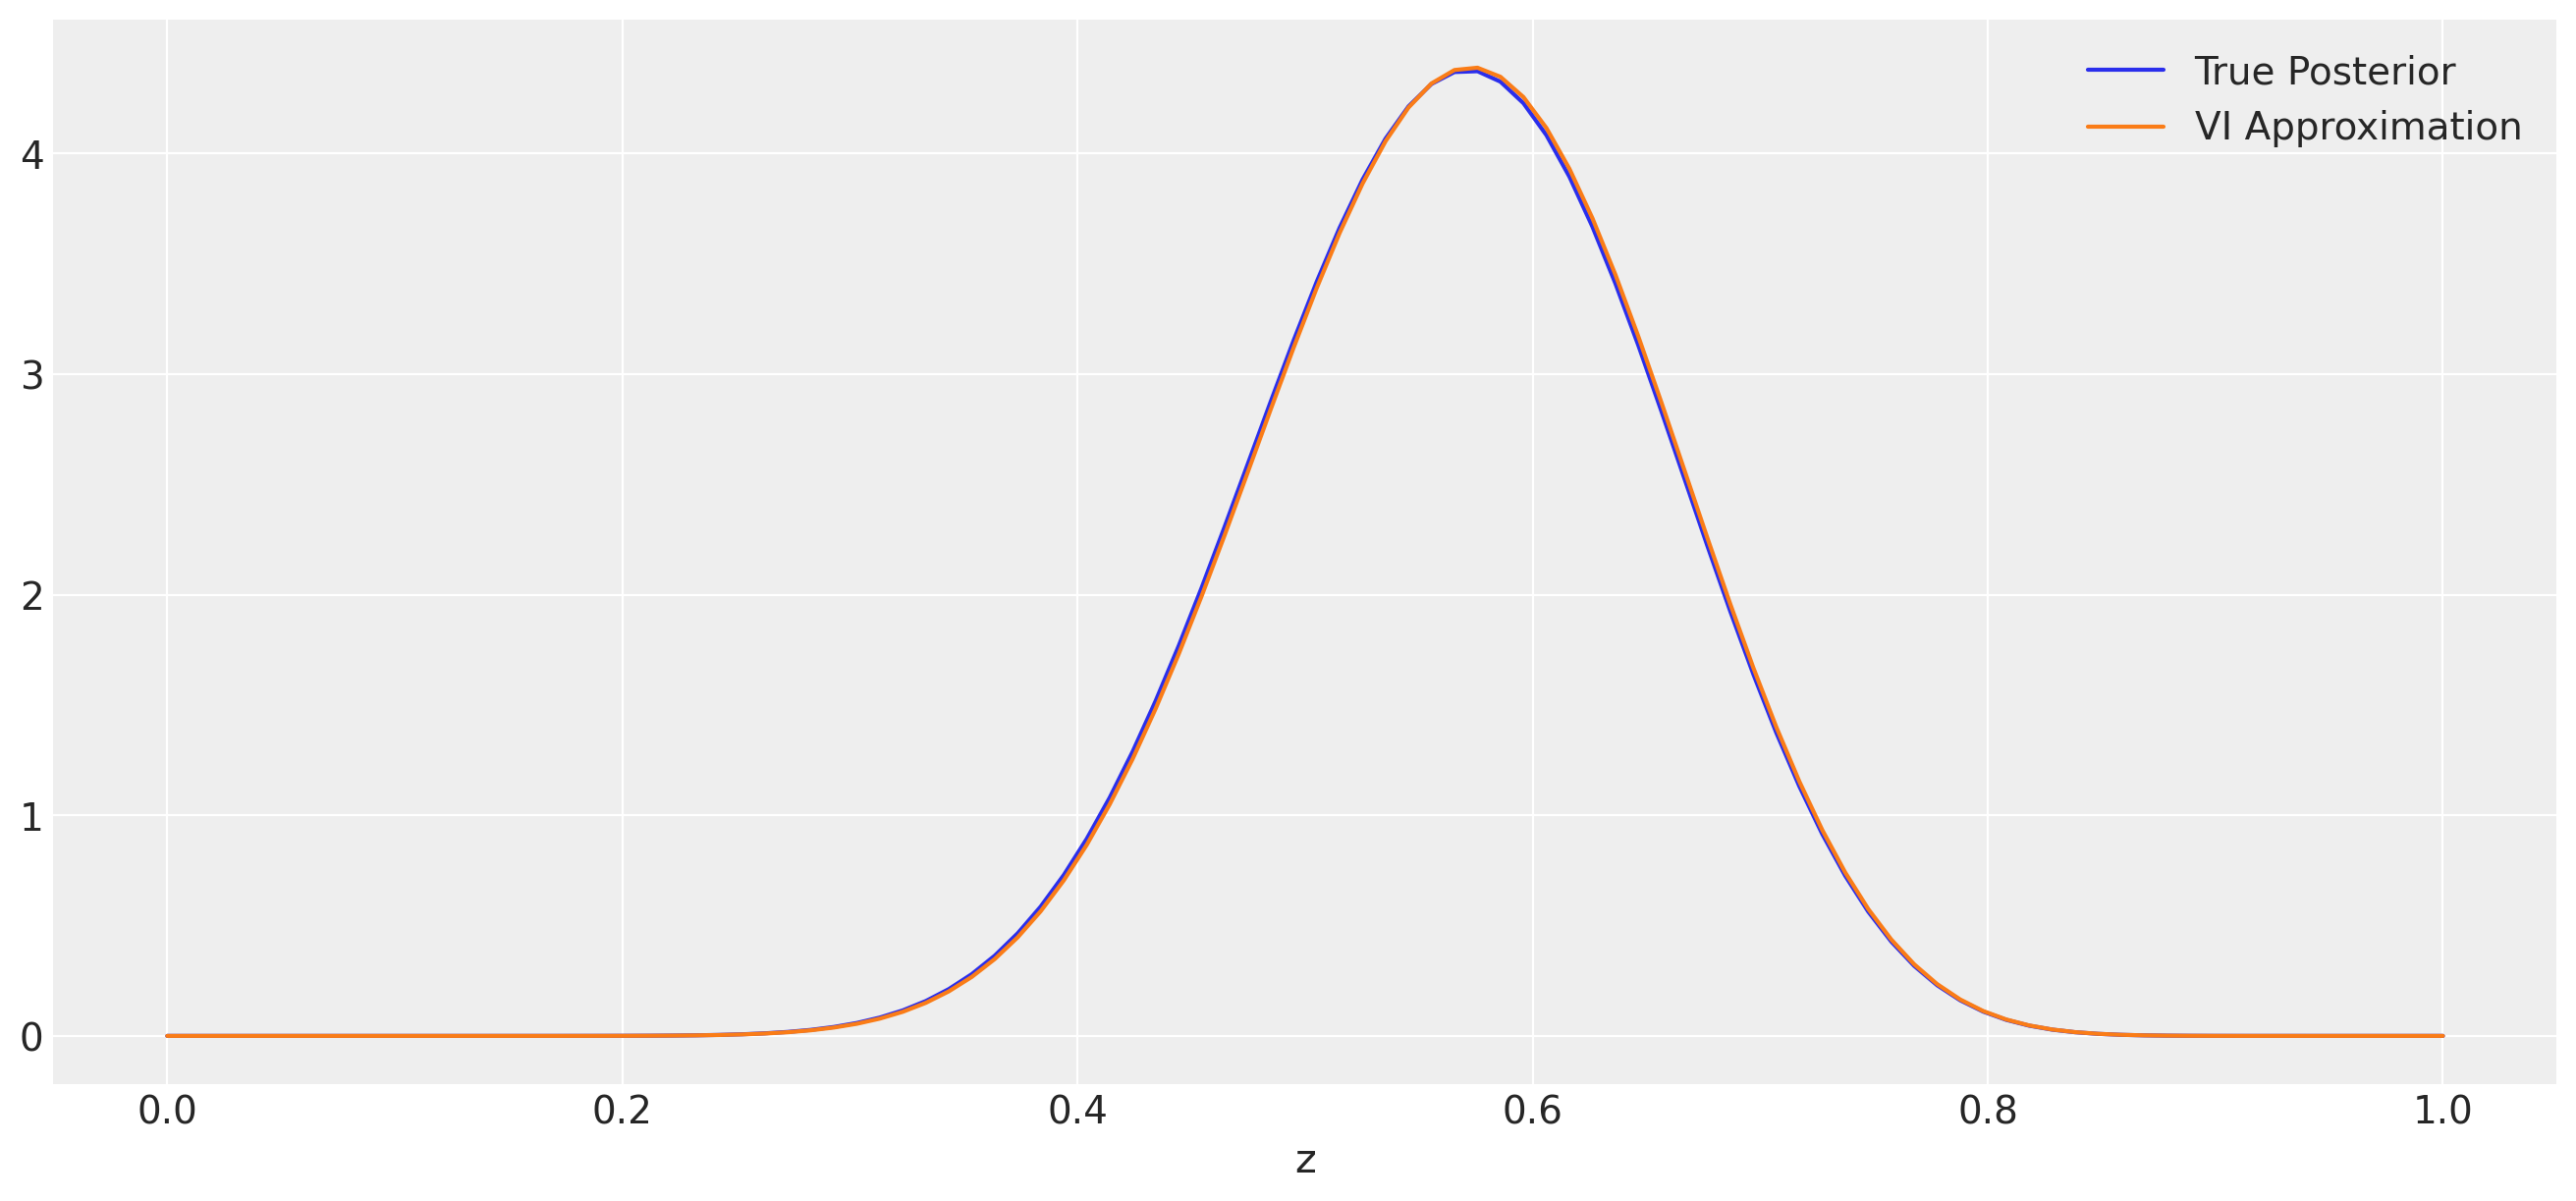

In [22]:
variational_posterior = [beta_dist.pdf(z_i, alpha_q, beta_q) for z_i in z_range]
# change figure size
plt.figure(figsize=(13,6))
sns.lineplot(x=z_range, y=posterior)
sns.lineplot(x=z_range, y=variational_posterior)
plt.xlabel('z')
plt.legend(labels=['True Posterior', 'VI Approximation'])
plt.show()